In [5]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split as tts

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import warnings
warnings.filterwarnings('ignore')

# EDA

In [7]:
data_start = pd.read_csv('/content/ner_data_train.csv')
data_start['entities'].sample(3)

324     {"label":"Дата"\,"offset":26\,"length":6\,"seg...
1340    {"label":"Дата"\,"offset":75\,"length":10\,"se...
6027    {"label":"локация"\,"offset":409\,"segment":"М...
Name: entities, dtype: object

In [8]:
data_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6422 entries, 0 to 6421
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_info  6422 non-null   object
 1   entities    6422 non-null   object
dtypes: object(2)
memory usage: 100.5+ KB


In [9]:
# данные спарсены с Толоки, поэтому могут иметь проблемы с символами и их нужно избежать,
# удалить лишние '\' например, преобразовать из str в список dict-ов
import json
df = data_start.copy()
df['entities'] = df['entities'].apply(lambda l: l.replace('\,', ',')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: l.replace('\\\\', '\\')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: '[' + l + ']'if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: json.loads(l)if isinstance(l, str) else l)

In [10]:
pip install razdel

In [11]:
from razdel import tokenize

def extract_labels(item):

    # воспользуемся удобным токенайзером из библиотеки razdel,
    # она помимо разбиения на слова, сохраняет важные для нас числа - начало и конец слова в токенах

    raw_toks = list(tokenize(item['video_info']))
    words = [tok.text for tok in raw_toks]
    # присвоим для начала каждому слову тег 'О' - тег, означающий отсутствие NER-а
    word_labels = ['O'] * len(raw_toks)
    char2word = [None] * len(item['video_info'])
    # так как NER можем состаять из нескольких слов, то нам нужно сохранить эту инфорцию
    for i, word in enumerate(raw_toks):
        char2word[word.start:word.stop] = [i] * len(word.text)

    labels = item['entities']
    if isinstance(labels, dict):
        labels = [labels]
    if labels is not None:
        for e in labels:
            if e['label'] != 'не найдено':
                e_words = sorted({idx for idx in char2word[e['offset']:e['offset']+e['length']] if idx is not None})
                if e_words:
                    word_labels[e_words[0]] = 'B-' + e['label']
                    for idx in e_words[1:]:
                        word_labels[idx] = 'I-' + e['label']
                else:
                    continue
            else:
                continue
        return {'tokens': words, 'tags': word_labels}
    else: return {'tokens': words, 'tags': word_labels}

In [12]:
from sklearn.model_selection import train_test_split
ner_data = [extract_labels(item) for i, item in df.iterrows()]

In [ ]:
ner_data[0]

In [14]:
label_list = sorted({label for item in ner_data for label in item['tags']})
if 'O' in label_list:
    label_list.remove('O')
    label_list = ['O'] + label_list
label_list

['O',
 'B-Дата',
 'B-бренд',
 'B-вид спорта',
 'B-видеоигра',
 'B-команда',
 'B-лига',
 'B-локация',
 'B-модель',
 'B-название проекта',
 'B-организация',
 'B-персона',
 'B-сезон',
 'B-серия',
 'I-Дата',
 'I-бренд',
 'I-вид спорта',
 'I-видеоигра',
 'I-команда',
 'I-лига',
 'I-локация',
 'I-модель',
 'I-название проекта',
 'I-организация',
 'I-персона',
 'I-сезон',
 'I-серия']

In [15]:
from itertools import repeat

In [16]:
count_labels = dict(zip(label_list, repeat(0)))

In [17]:
for i in range(len(ner_data)):
  for j in ner_data[i]['tags']:
    count_labels[j] += 1

Взглянем на распределение по классам на всех данных

In [19]:
count_labels = dict(sorted(count_labels.items(), key=lambda item: item[1], reverse=True))

In [20]:
del count_labels['O']

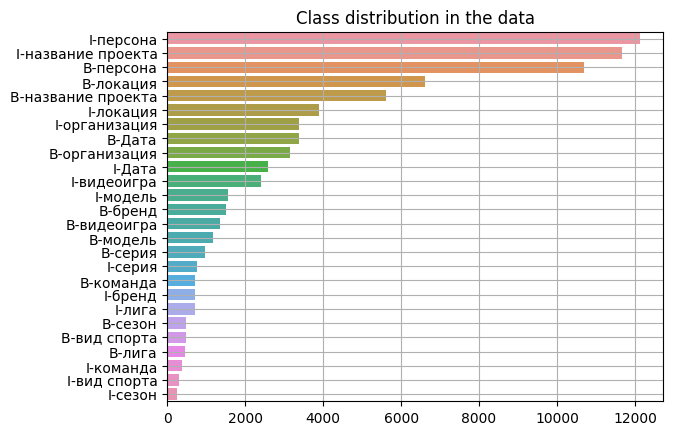

In [21]:
g = sns.barplot(x=list(count_labels.values()), y=list(count_labels.keys()), )
plt.grid()
plt.title("Class distribution in the data");

## Краткая лемматизация для анализа данных

In [22]:
import pandas as pd
pd.options.display.max_colwidth = 300
data = pd.DataFrame(ner_data)
pd.DataFrame(ner_data).sample(3)

,tokens,tags
6130,"[<, НАЗВАНИЕ, :, >, МОЙ, ДРУГ, СТАЛ, МУМИЕЙ, НА, ОДНОМ, БЛОКЕ, В, ОКЕАНЕ, МАЙНКРАФТ, !, <, ОПИСАНИЕ, :, >, ►, МЕНЯ, ПОХОРОНИЛИ, ЗАЖИВО, НА, ОДНОМ, НА, ОДНОМ, БЛОКЕ, В, ОКЕАНЕ, :, <, LINK, >, ►, Мой, Телеграм, :, <, LINK, >, ●, Мой, Инстаграм, :, <, LINK, >, /, ●, Я, ВКонтакте, :, <, LINK, >, ●, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-видеоигра, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
360,"[<, НАЗВАНИЕ, :, >, Заказать, танцевальный, шоу, балет, на, 23, февраля, ,, день, рождения, и, юбилей, Москва, <, ОПИСАНИЕ, :, >, Заказать, танцевальный, коллектив, на, 23, февраля, ,, свадьбу, ,, праздник, ,, юбилей, и, корпоратив, в, Москве, можно, по, телефону, 8, (, 495, ), 724, 63, 04, или,...","[O, O, O, O, O, O, O, O, O, B-Дата, I-Дата, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Дата, I-Дата, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
8,"[<, НАЗВАНИЕ, :, >, Международный, Проект, «, Победа, без, границ, », ., "", На, братских, могилах, "", ., <, ОПИСАНИЕ, :, >, НА, БРАТСКИХ, МОГИЛАХ, Автор, Владимир, Высоцкий, Исполняет, Инна, Субботина, Международный, Проект, «, Победа, без, границ, », Шымкент, Алматы, Балхаш, Караганда, Астана, ...","[O, O, O, O, O, O, O, B-название проекта, I-название проекта, I-название проекта, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-персона, I-персона, O, B-персона, I-персона, O, O, O, B-название проекта, I-название проекта, I-название проекта, O, B-локация, B-локация, B-локация, B-локация, B-л..."


In [23]:
k = False
for n, i in enumerate(data['tags']):
  for j in i:
    if j != 'О':
      k = True
      break
  if k == False:
    print(n)

In [24]:
data['video_info'] = data_start['video_info']

In [25]:
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

#Create lemmatizer and stopwords list
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [26]:
m = MorphAnalyzer(lang='ru')
regex = re.compile("[А-Яа-яA-z0-9]+")
mystopwords = russian_stopwords

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    if 'NOUN' in pymorphy.parse(token)[0].tag:
      return pymorphy.parse(token)[0].normal_form
    elif token.isdigit():
      return token
    else:
      return ''

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords\
            and w!='ну' and w!='название' and w!='описание' and w!='link']

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [27]:
from tqdm import tqdm

In [28]:
from multiprocessing import Pool as PoolSklearn
#train
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, data['video_info']), total=len(data)))

data['text_lemmas'] = lemmas

100%|██████████| 6422/6422 [02:13<00:00, 48.24it/s]


In [37]:
k = 0
for i in data['tokens']:
  if len(i) > k:
    k = len(i)
print(k)

367


## Визуализация

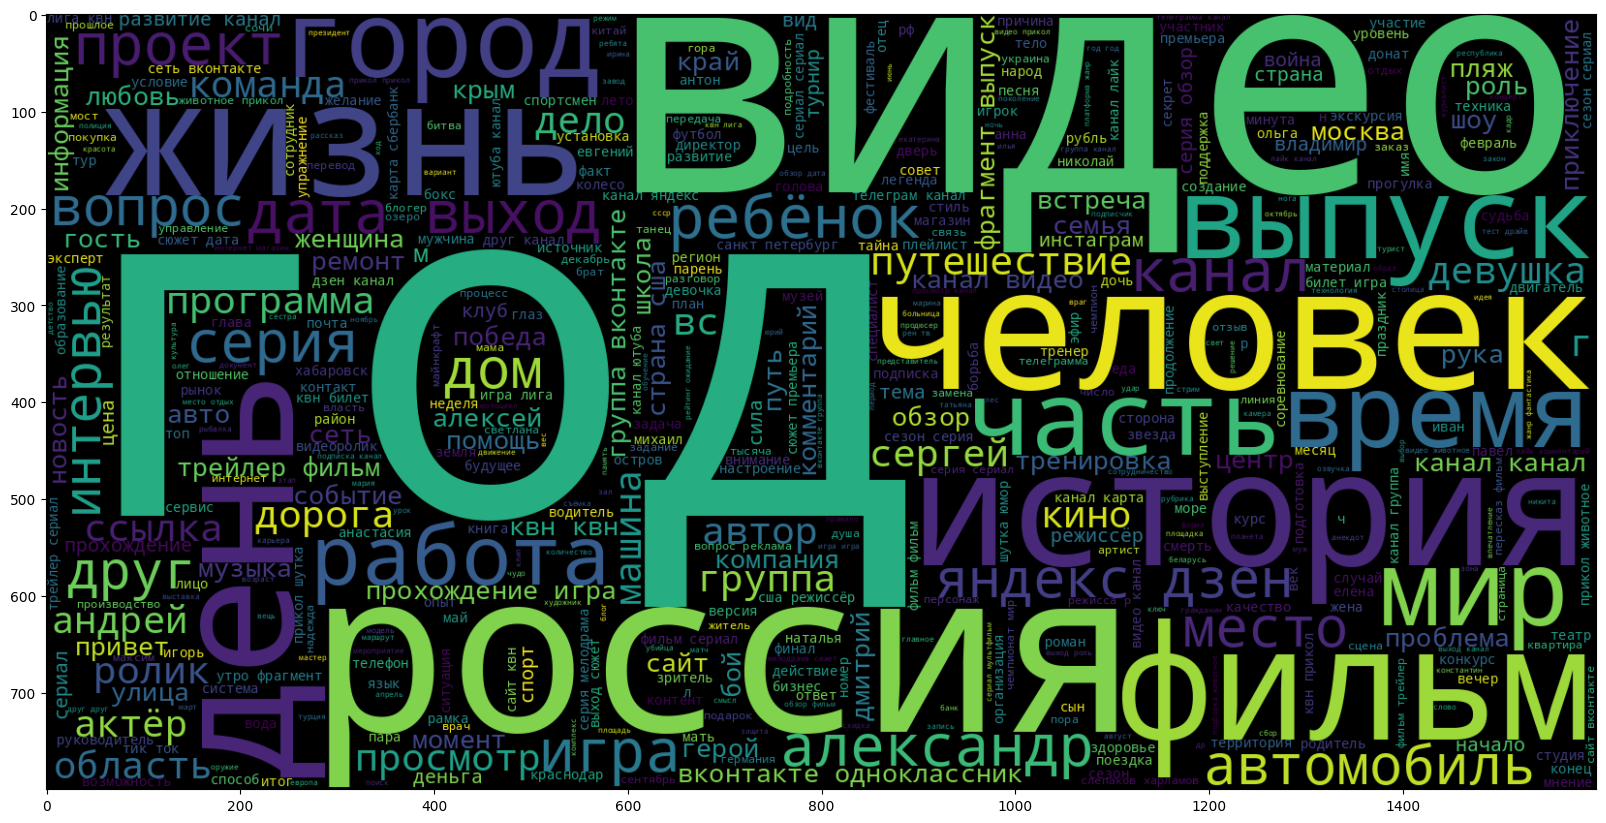

In [30]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = STOPWORDS)
wc.generate(' '.join(data.sample(n=5000)['text_lemmas']))
plt.imshow(wc , interpolation = 'bilinear')

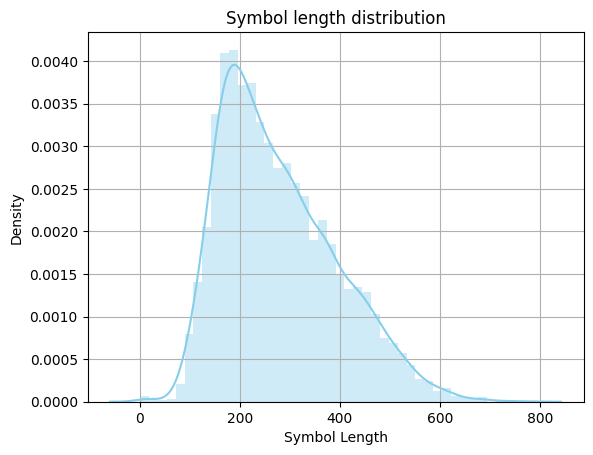

In [31]:
data['sym_len'] = data.text_lemmas.apply(len)
data['word_len'] = data.text_lemmas.apply(lambda x: len(x.split()))
data = data[data.sym_len > 0]
r = sns.distplot(data["sym_len"] , color="skyblue", axlabel='Symbol Length')
plt.grid()
plt.title("Symbol length distribution");

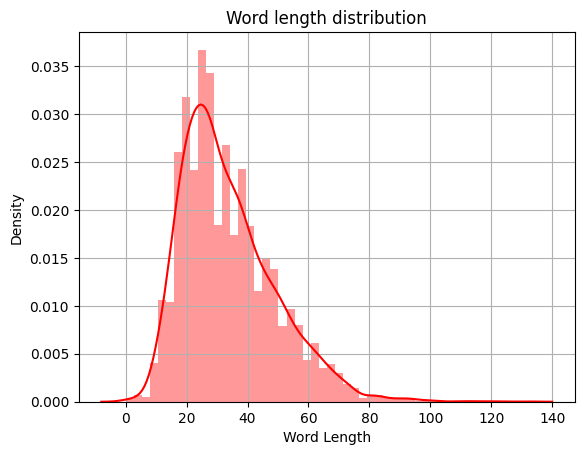

In [32]:
r = sns.distplot(data['word_len'] , color="red", axlabel="Word Length")
plt.grid()
plt.title("Word length distribution");